### Stress Points
-  If no customer is present and all customer is None then group_method should be `post code level`, else default to `Customer level`
-  `BI Agent` -> `Insight Agent`
-  Pass the parameters in the chat history, to keep track of parameters during comparison
-  Both the agents should be called during comparison
-  add a button to clear messages
-  remove drivers agent
-  Conversation Flow:
    - From the top 50 customers by size, please list down top 10 customers with highest cost per pallet in last 6 months
    - What is the cost per pallet per month for the last 6 months for ASDA WAL-MART STORES
    - What is the average number of pallets per order trends for this customer for the last 6 months
    - How I can optimise my costs for this customer in Jan with static consolidation by delivering only 2 days a week

- Keep only one version
- Fix bugs and error
    - To update the prompts according to the latest data available (Make sure date range is same in all)
        - Begining with `Prompt1.txt` used in "BIAgent_Node"
        - Go match in `bi_agent_prompt.txt` used in "BIAgent_Node"
        - Then go in `cost_parameters_prompt.txt` Used in "get_chatgpt_response"
        - Then finally check `customer_postcode_matching_prompt.txt` used in "ask_openai"
    - Fix `get_parameters_values` by making sure all the parameters are extracted accordingly to the question
    - No instruction is mentioned on how to extract the customer name from the question.
- Validation (BI Agent,)
- Extracted parameters from memory (how supervisor should use this memory)
- Make supervisor understand, to put more weightage on recent conversation

In [1]:
import os
import openai
import sys
import re
import uuid
import pandas as pd
import streamlit as st
import functools
import warnings
from dotenv import load_dotenv, find_dotenv

from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
import operator

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage
from langchain.schema import HumanMessage

In [2]:
# Define the path to the module directory (only the folder, not the .py file)
module_dir = os.path.abspath("/Users/ay/Desktop/MultiAgent_Perrigo/Perrigo-genai_v3")

# Add it to sys.path if not already present
if module_dir not in sys.path:
    sys.path.append(module_dir)


In [3]:
from config import display_saved_plot
from src.agents.BIAgent_Node import BIAgent_Class, execute_analysis
from src.orchestrater.supervisor import supervisor_chain, members
from src.agents.CostOptimization_Node import AgenticCostOptimizer
from src.agents.Static_CostOptimization_Node import Static_CostOptimization_Class
from src.utils.openai_api import get_supervisor_llm
from src.utils.load_templates import load_template
from src.core.order_consolidation.consolidation_ui import show_ui_cost_saving_agent, show_ui_cost_saving_agent_static
from src.core.order_consolidation.dynamic_consolidation import get_parameters_values,get_chatgpt_response

2025-04-03 18:56:59.508 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-03 18:56:59.509 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-04-03 18:57:00.127 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-03 18:57:00.565 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [5]:
from IPython.display import display, Image as IPythonImage

-------

In [6]:
# Load environment variables
_ = load_dotenv(find_dotenv())

llm = get_supervisor_llm()

2025-04-03 18:57:00.645 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [7]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    next: str

In [8]:
def display_saved_plot2(plot_path: str) -> None:
    """
    Loads and displays a saved plot from the given path using IPython display to prevent non-interactive warnings.

    Args:
        plot_path (str): Path to the saved plot image.
    """
    if os.path.exists(plot_path):
        display(IPythonImage(filename=plot_path))
    else:
        print(f"Plot not found at {plot_path}")

In [9]:
def get_question(state, supervisor_chain):
    """
    Extract a single-line question from the conversation history to pass to an agent.
    """
    all_msg = []
    for msg in state['messages']:
        all_msg.append(msg.content)

    text = f"""Next agent to be called, use this conversation: {"\n".join(all_msg)} to create a single 
    line question to be passed next to this agent as a question. Keep track of these parameters while summarising:
        start_date;
        end_date;
        group_method;
        all_post_code; 
        all_customers;
        selected_postcodes; 
        selected_customers;
        scenario;
        shipment_window_range;
        total_shipment_capacity;
        utilization_threshold;
        .Provide your answer in `direct_response`."""
    response = supervisor_chain.invoke([HumanMessage(content=text)])
    print("Inside Get Question; Direct_response\n", response['direct_response'])
    return response

In [10]:
prev_cws = os.getcwd()
os.chdir(module_dir)

In [11]:
question = "What is the cost per pallet per month for the last 6 months for ASDA WAL-MART STORES?"

In [12]:
instructions = load_template("cost_parameters_prompt.txt")
print(instructions)

You are an AI assistant tasked with analyzing questions and, based on that, providing values for certain variables. List of variables are below:
start_date:
end_date:
group_method:
all_post_code: 
all_customers:
selected_postcodes: 
selected_customers:
scenario:
shipment_window_range:
total_shipment_capacity:
utilization_threshold:

I will provide you a question to answer. Based on the question you need to provide variable values.

Here are some sample questions I would like you to answer:
1. How can I optimize the shipment costs for user ALLOGA UK?
2. Can you optimize costs for shipments to zip code NG between January and March 2024?
3. Optimize shipments for a '3 days delivery scenario' with shipment window range 2 to 8, total shipment capacity 40 and utilization threshold 90.
4. Optimize shipment costs for the last6 months.
5. Optimize shipment costs for the next6 months.

To answer this, first think through your approach:
1. Determine the start and end date. The "SHIPPED_DATE" colu

In [13]:
response = get_chatgpt_response(openai.api_key, instructions, question)

In [14]:
print(response)

{
    "start_date": "2024-08-01",
    "end_date": "2025-01-31",
    "group_method": "Customer Level",
    "all_post_code": None,
    "all_customers": False,
    "selected_postcodes": [],
    "selected_customers": ["ASDA WAL-MART STORES"],
    "scenario": None,
    "shipment_window_range": [1, 10],
    "total_shipment_capacity": 36,
    "utilization_threshold": 95
}


In [15]:
prompt_template = load_template("customer_postcode_matching_prompt.txt")

In [16]:
extracted_params = get_parameters_values(openai.api_key, question,attempt=0)

['ASDA WAL-MART STORES', 'ASDA WAL-MART STORE']
[]


In [10]:
from src.orchestrater.MultiAgentGraph import supervisor_node

In [11]:
ques = "For the top 50 customers by size, please list down top 10 customers with highest cost per pallet in last 6 months"

In [12]:
state = {"messages":[HumanMessage(content=ques)],"next":"supervisor"}

### Flow:
- `UserQuestion` -> Add to state -> `supervisor_chain.invoke(state)` -> Route to next of `supervisor_node` -> `BIAgent`
  -> question from `get_question` , `extract_params`, `bi_prompt`, `data_description`

#### Supervisor Role: prompt and Instructions

In [13]:
from langchain_core.prompts import ChatPromptTemplate

# Assuming 'supervisor_chain' is your RunnableSequence instance

# Iterate through the runnables in the sequence
for runnable in supervisor_chain.steps:
    if isinstance(runnable, ChatPromptTemplate):
        # Access the messages attribute
        messages = runnable.messages
        # Iterate through messages to find the template
        for message in messages:
            if hasattr(message, 'prompt') and hasattr(message.prompt, 'template'):
                template_message = message.prompt.template
                print(template_message)
        break
else:
    print("No ChatPromptTemplate found in the RunnableSequence.")


You are a Multi-Agent Supervisor responsible for managing the conversation flow between multiple agents.
Your role is to analyze user queries and orchestrate responses efficiently by assigning tasks to the appropriate agents.

The Supervisor analyzes the conversation history, decides which agent should act next, and routes the conversation accordingly.
The Supervisor ensures smooth coordination and task completion by assigning specific roles to agents.

You also have the capability to answer simple questions directly without routing to specialized agents.
This improves efficiency and user experience for straightforward queries.

Use step-by-step reasoning (Chain-of-Thought) before deciding which agent should act next or if you should answer directly.
Upon receiving responses, reflect and dynamically adjust the approach using ReAct to ensure an optimal solution.

Please try to follow the below mentioned instructions:
1. Analyze the user's query and determine the best course of action.
2

In [14]:
result = supervisor_chain.invoke(state['messages'])

In [15]:
print(f"Question: -\n{ques}")
print("-"*30)
print(f"Supervisor Response: -")
print("\n")
for k,v in result.items():
    if k=='thought_process':
        print(k,v,sep=" :\n")
        print("\n")
        continue
    print(k,v,sep=" : ")
print("-"*30)

Question: -
For the top 50 customers by size, please list down top 10 customers with highest cost per pallet in last 6 months
------------------------------
Supervisor Response: -


thought_process :
The user is asking for an analysis of shipment data to identify the top 10 customers with the highest cost per pallet among the top 50 customers by size over the last 6 months. This requires analyzing shipment data to calculate cost per pallet for each customer and then ranking them. The Insights Agent is best suited for this task as it involves data analysis and comparison of metrics across customers.


next : Insights Agent
direct_response : 
------------------------------


### Going inside `Insights Agent`


In [17]:
data_path = os.path.join(module_dir,"src", "data", "Outbound_Data.csv")
df = pd.read_csv(data_path)

# Load data description
data_description = load_template("Outbound_data.txt")

# Load BI Agent prompt
bi_prompt = load_template("bi_agent_prompt.txt")

# Define helper functions
helper_functions = {"execute_analysis": execute_analysis}

# Initialize BI Agent
agent_instance = BIAgent_Class(
    llm=llm, 
    prompt=bi_prompt, 
    tools=[], 
    data_description=data_description, 
    dataset=df, 
    helper_functions=helper_functions
)

In [24]:
from jinja2 import Template

In [27]:
print(data_description)

Here is an example of what one row of the data looks like in json format but I will provide you with first 5 rows of the dataframe inside <data> tags:
{{
      "PROD_TYPE": "AMBCONTROL",
      "Customer": "GR & MM BLACKLEDGE PLC", 
      "SHIPPED_DATE": "01-01-2024",
      "Total_Orders": 2,
      "Total_Pallets": 2,
      "Distance": 134.5,
      "Cost": 102.8,
      "SHORT_POSTCODE": "PR"}}

<data>
{{df.head().to_string()}}
</data>

Some key things to note about the data:
- The "PROD_TYPE" column includes 2 values, either "AMBIENT" or "AMBCONTROL"
- The "SHIPPED_DATE" column ranges from Jan 2023 to Feb 2025 and is in dd-mm-yyyy format
- The "Cost" is in Pounds(£)


In [18]:
current_state = {"messages": [AIMessage(content=result.get('thought_process'))], "next": result.get('next')}
state['messages'] = add_messages(state['messages'], current_state['messages'])
state['next'] = current_state['next']

In [19]:
print("Messages in current state:\n")
print("-"*30)
for i,msg in enumerate(state['messages']):
    print(i+1,".",msg.content,end='\n\n')
print("-"*30)
print(f"Next node to go: {current_state['next']}")

Messages in current state:

------------------------------
1 . For the top 50 customers by size, please list down top 10 customers with highest cost per pallet in last 6 months

2 . The user is asking for an analysis of shipment data to identify the top 10 customers with the highest cost per pallet among the top 50 customers by size over the last 6 months. This requires analyzing shipment data to calculate cost per pallet for each customer and then ranking them. The Insights Agent is best suited for this task as it involves data analysis and comparison of metrics across customers.

------------------------------
Next node to go: Insights Agent


- Get a single line question using `get_question` from all the previous state['messages'] by passing these to supervisor_chain to summarise.

In [20]:
response = get_question(state,supervisor_chain)

Inside Get Question; Direct_response
 Analyze shipment data from the last 6 months to identify the top 10 customers with the highest cost per pallet among the top 50 customers by size.


In [21]:
print(f"Question: -\n{ques}")
print("-"*30)
print(f"Supervisor Response: -")
print("\n")
for k,v in response.items():
    if k=='thought_process':
        print(k,v,sep=" :\n")
        print("\n")
        continue
    print(k,v,sep=" : ")
print("-"*30)

Question: -
For the top 50 customers by size, please list down top 10 customers with highest cost per pallet in last 6 months
------------------------------
Supervisor Response: -


thought_process :
The user is asking for an analysis of shipment data to identify the top 10 customers with the highest cost per pallet among the top 50 customers by size over the last 6 months. This requires analyzing shipment data to calculate cost per pallet for each customer and then ranking them. The Insights Agent is best suited for this task as it involves data analysis and comparison of metrics across customers.


next : Insights Agent
direct_response : Analyze shipment data from the last 6 months to identify the top 10 customers with the highest cost per pallet among the top 50 customers by size.
------------------------------


In [22]:
question = response['direct_response']
print(f"Question to be passed into `BIAgent`:\n\n{question}")

Question to be passed into `BIAgent`:

Analyze shipment data from the last 6 months to identify the top 10 customers with the highest cost per pallet among the top 50 customers by size.


#### Now we will enrich this question with the parameters to be used:

In [23]:
print(f"Extract parameters for '{question}' from question prompt:\n")
print("-"*30*3)
print(load_template("cost_parameters_prompt.txt"))
print("-"*30*3)
print("Extracted Parameters:")
extracted_params = get_parameters_values(openai.api_key, question,attempt=0)
for k,v in extracted_params.items():
    print(k,v,sep=" : ")

Extract parameters for 'Analyze shipment data from the last 6 months to identify the top 10 customers with the highest cost per pallet among the top 50 customers by size.' from question prompt:

------------------------------------------------------------------------------------------
You are an AI assistant tasked with analyzing questions and, based on that, providing values for certain variables. List of variables are below:
start_date:
end_date:
group_method:
all_post_code: 
all_customers:
selected_postcodes: 
selected_customers:
scenario:
shipment_window_range:
total_shipment_capacity:
utilization_threshold:

I will provide you a question to answer. Based on the question you need to provide variable values.

Here are some sample questions I would like you to answer:
1. How can I optimize the shipment costs for user ALLOGA UK?
2. Can you optimize costs for shipments to zip code NG between January and March 2024?
3. Optimize shipments for a '3 days delivery scenario' with shipment wi

In [24]:
print(agent_instance.prompt.format(data_description=data_description,
                                   question=question+f"Use these parameters to filter data: {extracted_params}"))

You are an AI assistant tasked with analyzing a dataset to provide code for calculating the final answer and generating relevant visualization.
I will provide you with the data in dataframe format, as well as a question to answer based on the data.


Here is an example of what one row of the data looks like in json format but I will provide you with first 5 rows of the dataframe inside <data> tags:
{{
      "PROD_TYPE": "AMBCONTROL",
      "Customer": "GR & MM BLACKLEDGE PLC", 
      "SHIPPED_DATE": "01-01-2024",
      "Total_Orders": 2,
      "Total_Pallets": 2,
      "Distance": 134.5,
      "Cost": 102.8,
      "SHORT_POSTCODE": "PR"}}

<data>
{{df.head().to_string()}}
</data>

Some key things to note about the data:
- The "PROD_TYPE" column includes 2 values, either "AMBIENT" or "AMBCONTROL"
- The "SHIPPED_DATE" column ranges from Jan 2023 to Feb 2025 and is in dd-mm-yyyy format
- The "Cost" is in Pounds(£)

Here is the question I would like you to answer using this data:
<question

In [26]:
response =agent_instance.generate_response(question)

Extracting parameters from question...
{
    "start_date": "2024-05-01",
    "end_date": "2024-10-31",
    "group_method": "Customer Level",
    "all_post_code": None,
    "all_customers": True,
    "selected_postcodes": [],
    "selected_customers": [],
    "scenario": None,
    "shipment_window_range": [1, 10],
    "total_shipment_capacity": 36,
    "utilization_threshold": 95
}
[]
[]
Insights Agent, Response Text
 <approach>
To answer this question, I will need to:
1. Filter the data for shipments between '2024-05-01' and '2024-10-31'.
2. Group the data by 'Customer' and calculate the total pallets and total cost for each customer.
3. Calculate the cost per pallet for each customer.
4. Identify the top 50 customers by total pallets.
5. From these top 50 customers, find the top 10 customers with the highest cost per pallet.
6. Visualize the top 10 customers with the highest cost per pallet using a bar chart.
</approach>

<code>
import pandas as pd

# Convert SHIPPED_DATE to datetime


In [39]:
print(res['output'])

The top 10 customers with the highest cost per pallet among the top 50 customers by size in the last 6 months are:

1. PRIMA BRANDS LTD - 155.70
2. ASDA GRANGEMOUTH ADC 7491 - 93.52
3. ALDI STORES LTD (BATHGATE) - 81.31
4. ASDA WAL-MART STORES - 53.42
5. ASDA GALLEON BOULEVARD 7442 - 53.26
6. ASDA CHEPSTOW ADC2 7441 - 53.19
7. ALDI STORES LTD (SWINDON) - 49.25
8. DAY LEWIS MEDICAL LIMITED - 49.00
9. T J MORRIS LTD (SOLSTICE BUS.) - 47.85
10. TESCO GROCERY DIST'N CENTRE (R) - 43.29


To answer this question, I will need to:
1. Filter the data for shipments between '2024-05-01' and '2024-10-31'.
2. Group the data by 'Customer' and calculate the total pallets and total cost for each customer.
3. Calculate the cost per pallet for each customer.
4. Identify the top 50 customers by total pallets.
5. From these top 50 customers, find the top 10 customers with the highest cost per pallet.
6. Visualize the top 10 customers with the highest cost per pallet using a bar chart.


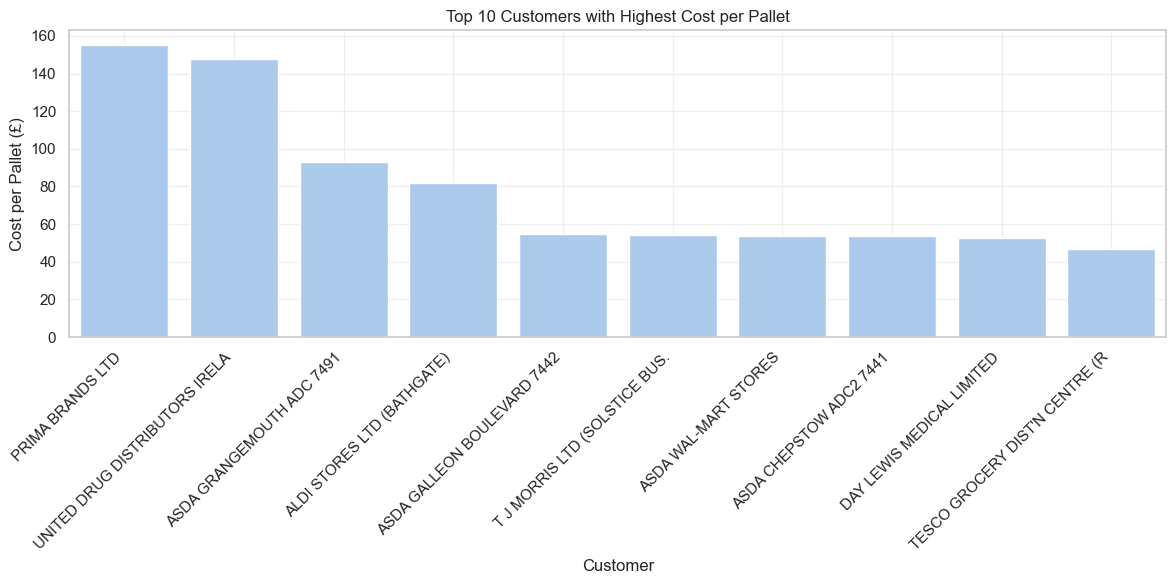

The top 10 customers with the highest cost per pallet among the top 50 customers by size from May 2024 to October 2024 are: ['PRIMA BRANDS LTD', 'UNITED DRUG DISTRIBUTORS IRELA', 'ASDA GRANGEMOUTH ADC 7491', 'ALDI STORES LTD (BATHGATE)', 'ASDA GALLEON BOULEVARD 7442', 'T J MORRIS LTD (SOLSTICE BUS.', 'ASDA WAL-MART STORES', 'ASDA CHEPSTOW ADC2 7441', 'DAY LEWIS MEDICAL LIMITED', "TESCO GROCERY DIST'N CENTRE (R"] with respective cost per pallet values of [155.12877358490567, 147.44356435643564, 93.06521739130434, 81.68716216216217, 54.76107382550335, 54.33512605042017, 53.779797979797976, 53.48837209302326, 52.48154761904762, 46.633333333333326].
Code
 import pandas as pd

# Convert SHIPPED_DATE to datetime
df['SHIPPED_DATE'] = pd.to_datetime(df['SHIPPED_DATE'], format='%d-%m-%Y')

# Filter data for the last 6 months
filtered_df = df[(df['SHIPPED_DATE'] >= '2024-05-01') & (df['SHIPPED_DATE'] <= '2024-10-31')]

# Group by Customer and calculate total pallets and total cost
customer_group

In [27]:
print(response['approach'])
display_saved_plot2(response['figure'])
print(response['answer'])
print("Code\n",response['code'])

{
    "start_date": "2024-01-01",
    "end_date": "2024-01-31",
    "group_method": "Customer Level",
    "all_post_code": None,
    "all_customers": False,
    "selected_postcodes": [],
    "selected_customers": ["ASDA WAL-MART STORES"],
    "scenario": None,
    "shipment_window_range": [1, 10],
    "total_shipment_capacity": 36,
    "utilization_threshold": 95
}
['ASDA WAL-MART STORES', 'ASDA']
[]


In [28]:
# prompt_temp = ChatPromptTemplate.from_messages(
#             [
#                 ("system", agent_instance.prompt.strip()),
#                 MessagesPlaceholder(variable_name="messages"),
#             ]
#         )

In [29]:
# final_prompt = prompt_temp.invoke({"data_description": agent_instance.data_description,
#                                                 "question": question+f"Use thes parameters to filter data: {extracted_params}",
#                                                 "messages": [HumanMessage(content=question)]})

In [30]:
# final_prompt.messages[1].type

In [31]:
# for msg in final_prompt.messages:
#     print(msg.type,msg.content,sep='\n')
#     print('-'*30)

In [39]:
question

'Analyze the shipment data from the last 6 months to identify the top 10 customers with the highest cost per pallet among the top 50 customers by size.'

In [32]:
from langchain_experimental.agents import create_pandas_dataframe_agent

In [33]:
# df2 = df.copy()
# df2['SHIPPED_DATE'] = pd.to_datetime(df2['SHIPPED_DATE'], dayfirst=True)

In [45]:
ques

'For the top 50 customers by size, please list down top 10 customers with highest cost per pallet in last 6 months'

In [117]:
ques = "Identify the top customer for January 2024?"

In [118]:
text = f"""For a given question '{ques}' identify the following parameters, which are required to be passed into different algos. So, please focus on 
extracting the correct parameters for following variables: <`start_date`,`end_date`>. This will be applied to filter data. Identify and use
relevant column for extracting these variables. Do not assume anything rather try to deduce and arrive at the results. Keep your answer as concise as possible."""

In [119]:
res = create_pandas_dataframe_agent(
    llm,df,
    verbose=False, allow_dangerous_code=True,
    handle_parsing_errors=True, return_intermediate_steps=True
).invoke(text)

In [120]:
text

"For a given question 'Identify the top customer for January 2024?' identify the following parameters, which are required to be passed into different algos. So, please focus on \nextracting the correct parameters for following variables: <`start_date`,`end_date`>. This will be applied to filter data. Identify and use\nrelevant column for extracting these variables. Do not assume anything rather try to deduce and arrive at the results. Keep your answer as concise as possible."

In [121]:
res

{'input': "For a given question 'Identify the top customer for January 2024?' identify the following parameters, which are required to be passed into different algos. So, please focus on \nextracting the correct parameters for following variables: <`start_date`,`end_date`>. This will be applied to filter data. Identify and use\nrelevant column for extracting these variables. Do not assume anything rather try to deduce and arrive at the results. Keep your answer as concise as possible.",
 'output': "The parameters are `start_date = '2024-01-01'` and `end_date = '2024-01-31'`.",
 'intermediate_steps': [(AgentAction(tool='Define the start and end dates for January 2024.', tool_input="```python\nstart_date = '2024-01-01'\nend_date = '2024-01-31'\n(start_date, end_date)\n```\n", log="Thought: To identify the top customer for January 2024, we need to filter the data for that specific month. The relevant column for filtering by date is `SHIPPED_DATE`. We need to determine the start and end da

In [122]:
print(res['output'])

The parameters are `start_date = '2024-01-01'` and `end_date = '2024-01-31'`.


In [115]:
artifacts,_ = res['intermediate_steps'][0]

In [116]:
print(artifacts.log)

Thought: To determine the `start_date` and `end_date` for filtering the data, we need to consider the "last 6 months" from the most recent date in the `SHIPPED_DATE` column. We will first find the maximum date in the `SHIPPED_DATE` column to determine the `end_date`, and then calculate the `start_date` by subtracting 6 months from the `end_date`.

Action: python_repl_ast
Action Input: 
```python
import pandas as pd
from dateutil.relativedelta import relativedelta

# Convert SHIPPED_DATE to datetime
df['SHIPPED_DATE'] = pd.to_datetime(df['SHIPPED_DATE'])

# Find the maximum date in the SHIPPED_DATE column
end_date = df['SHIPPED_DATE'].max()

# Calculate the start date by subtracting 6 months from the end date
start_date = end_date - relativedelta(months=6)

start_date, end_date
```



In [57]:
res

{'input': "For a given question 'For the top 50 customers by size, please list down top 10 customers with highest cost per pallet in last 6 months' identify the following parameters, which are required to be passed into different algos. So, please focus on \nextracting the correct parameters for following variables: <`start_date`,`end_date`>. This will be applied to filter data. Identify and use\nrelevant column for extracting these variables. ",
 'output': 'The `start_date` is September 1, 2024, and the `end_date` is February 28, 2025.',
 'intermediate_steps': [(AgentAction(tool='python_repl_ast', tool_input='```python\nfrom datetime import datetime, timedelta\n\n# Current date\nend_date = datetime.now()\n\n# Date 6 months ago\nstart_date = end_date - timedelta(days=6*30)  # Approximation of 6 months\n\nstart_date, end_date\n```', log="To determine the `start_date` and `end_date` for filtering the data, we need to focus on the `SHIPPED_DATE` column, which contains the dates of the shi

In [55]:
print(artifacts.tool_input)

```python
# Convert SHIPPED_DATE to datetime
df['SHIPPED_DATE'] = pd.to_datetime(df['SHIPPED_DATE'])

# Find the maximum date in the SHIPPED_DATE column
current_date = df['SHIPPED_DATE'].max()

# Calculate the start date as 6 months before the current date
start_date = current_date - timedelta(days=6*30)  # Approximation of 6 months

current_date, start_date
```


In [37]:
res

{'input': 'Analyze shipment data from the last 6 months to identify the top 10 customers with the highest cost per pallet among the top 50 customers by size.',
 'output': "The top 10 customers with the highest cost per pallet among the top 50 customers by size in the last 6 months are:\n\n1. PRIMA BRANDS LTD - 155.70\n2. ASDA GRANGEMOUTH ADC 7491 - 93.52\n3. ALDI STORES LTD (BATHGATE) - 81.31\n4. ASDA WAL-MART STORES - 53.42\n5. ASDA GALLEON BOULEVARD 7442 - 53.26\n6. ASDA CHEPSTOW ADC2 7441 - 53.19\n7. ALDI STORES LTD (SWINDON) - 49.25\n8. DAY LEWIS MEDICAL LIMITED - 49.00\n9. T J MORRIS LTD (SOLSTICE BUS.) - 47.85\n10. TESCO GROCERY DIST'N CENTRE (R) - 43.29",
 'intermediate_steps': [(AgentAction(tool='python_repl_ast', tool_input="```python\nimport pandas as pd\nfrom datetime import datetime, timedelta\n\n# Convert SHIPPED_DATE to datetime\ndf['SHIPPED_DATE'] = pd.to_datetime(df['SHIPPED_DATE'])\n\n# Filter for the last 6 months\nsix_months_ago = datetime.now() - timedelta(days=6*30

In [38]:
print(res['output'])

The top 10 customers with the highest cost per pallet among the top 50 customers by size in the last 6 months are:

1. PRIMA BRANDS LTD - 155.70
2. ASDA GRANGEMOUTH ADC 7491 - 93.52
3. ALDI STORES LTD (BATHGATE) - 81.31
4. ASDA WAL-MART STORES - 53.42
5. ASDA GALLEON BOULEVARD 7442 - 53.26
6. ASDA CHEPSTOW ADC2 7441 - 53.19
7. ALDI STORES LTD (SWINDON) - 49.25
8. DAY LEWIS MEDICAL LIMITED - 49.00
9. T J MORRIS LTD (SOLSTICE BUS.) - 47.85
10. TESCO GROCERY DIST'N CENTRE (R) - 43.29


In [93]:
# res2 = create_pandas_dataframe_agent(
#     llm,df2,
#     verbose=False, allow_dangerous_code=True,
#     handle_parsing_errors=True, return_intermediate_steps=True
# ).invoke("What's the timeperiod for this data? I want to know about the starting and ending dates for this data.")

In [94]:
res2

{'input': "What's the timeperiod for this data? I want to know about the starting and ending dates for this data.",
 'output': 'The time period for this data starts on January 2, 2023, and ends on February 28, 2025.',
 'intermediate_steps': [(AgentAction(tool='python_repl_ast', tool_input="df['SHIPPED_DATE'].min(), df['SHIPPED_DATE'].max()", log="Thought: To determine the time period for the data, I need to find the minimum and maximum dates in the `SHIPPED_DATE` column of the dataframe `df`.\nAction: python_repl_ast\nAction Input: df['SHIPPED_DATE'].min(), df['SHIPPED_DATE'].max()"),
   (Timestamp('2023-01-02 00:00:00'), Timestamp('2025-02-28 00:00:00')))]}

In [91]:
res

{'input': "What's the timeperiod for this data? I want to know about the starting and ending dates for this data.",
 'output': 'The data covers the period from January 1, 2024, to October 31, 2024.',
 'intermediate_steps': [(AgentAction(tool='python_repl_ast', tool_input="df['SHIPPED_DATE'].min(), df['SHIPPED_DATE'].max()", log="Thought: To determine the time period for the data, I need to find the minimum and maximum dates in the `SHIPPED_DATE` column of the dataframe `df`.\nAction: python_repl_ast\nAction Input: df['SHIPPED_DATE'].min(), df['SHIPPED_DATE'].max()"),
   ('01-01-2024', '31-10-2024'))]}

-----

In [86]:
cat = 'Prescription'
cat_val = '1'
start_val = '1'
end_val = '28'

In [105]:
cat_ = 'Probiotics'
cat_val_ = '3'
start_val_ = '1'
end_val_ = '17'

In [254]:
cat = "LIEFSTYLE_ADVICE"
val = "c6"

syn = f"""COMPUTE CON_OCC_PrescriptionInfo_{cat}= 0.
IF ANY(1,B214r1001c1,B214r1002c1,B214r1003c1,B214r1004c1,B214r1005c1,B214r1006c1,B214r1007c1,B214r1008c1,B214r1009c1,B214r1010c1,
B214r1011c1,B214r1013c1,B214r1014c1,B214r1015c1,B214r1016c1,B214r1017c1,B214r1018c1,B214r1019c1,B214r1020c1,
B214r1021c1,B214r1022c1,B214r1023c1,B214r1024c1,B214r1025c1,B214r1026c1,B214r1027c1,B214r1028c1,B214r1098c1) CON_OCC_PrescriptionInfo_{cat}= 1.
"""

In [255]:
text = f"Replace `c1` with {val} in the given syntax: {syn} and rewrite it again. Only output the syntax"

In [256]:
# text2 = f"""These are the parameters: `cat: {cat}, cat_val: {cat_val}, start_val: {start_val}, end_val: {end_val}` for writing a given syntax: {syn}. Now, looking at the given syntax, rewrite a new syntax.
# For given parameters: `cat: {cat_}, cat_val: {cat_val_}, start_val: {start_val_}, end_val: {end_val_}`. Output only the syntax"""

In [257]:
# cat = 'Prescription'
# val = 'Nothing'

In [258]:
# syn3 = f"""COMPUTE CON_OCC_Action_LowerGI_{cat}=0.
# IF (ANY(xSymptomsSelect,11,12,13,14,15,16,17) AND CON_OCC_Action_{cat}=1) CON_OCC_Action_LowerGI_{cat}=1."""

In [259]:
# text3 = f"Replace `cat` : {cat} with `val`: {val} in the given syntax: {syn3} and rewrite it again. Only output the syntax"

In [260]:
# response = llm.invoke(text2.format(syn=syn,cat=cat,cat_val=cat_val,start_val=start_val,end_val=end_val,
#                                  cat_=cat_,cat_val_=cat_val_,start_val_=start_val_,end_val_=end_val_))
response = llm.invoke(text.format(syn=syn,cat=cat,val=val))
print(response.content)

COMPUTE CON_OCC_PrescriptionInfo_LIEFSTYLE_ADVICE= 0.
IF ANY(1,B214r1001c6,B214r1002c6,B214r1003c6,B214r1004c6,B214r1005c6,B214r1006c6,B214r1007c6,B214r1008c6,B214r1009c6,B214r1010c6,
B214r1011c6,B214r1013c6,B214r1014c6,B214r1015c6,B214r1016c6,B214r1017c6,B214r1018c6,B214r1019c6,B214r1020c6,
B214r1021c6,B214r1022c6,B214r1023c6,B214r1024c6,B214r1025c6,B214r1026c6,B214r1027c6,B214r1028c6,B214r1098c6) CON_OCC_PrescriptionInfo_LIEFSTYLE_ADVICE= 1.
